Hashtables
==========



## Agenda



-   Discussion: pros/cons of array-backed and linked structures
-   Comparison to `set` and `dict`
-   The *map* ADT
-   Direct lookups via *Hashing*
-   Hashtables
-   Chaining
-   Collisions and the "Birthday problem"
-   Open Addressing
-   Runtime analysis & Discussion



## Discussion: pros/cons of array-backed and linked structures



Between the array-backed and linked list we have:

1.  $O(1)$ indexing (array-backed)
2.  $O(1)$ appending (array-backed & linked)
3.  $O(1)$ insertion/deletion without indexing (linked)
4.  $O(N)$ linear search (unsorted)
5.  $O(\log N)$ binary search, when sorted (only array-backed lists)



## Comparison to `set` and `dict`



The `set` and `dict` types don't support positional access (i.e., by
index), but do support lookup/search. How fast do they fare compared to
lists?



In [2]:
import timeit

def lin_search(lst, x):
    return x in lst

def bin_search(lst, x):
    # assumes lst is sorted
    low = 0
    hi  = len(lst)-1
    while low <= hi:
        mid = (low + hi) // 2
        if x < lst[mid]:
            hi  = mid - 1
        elif x < lst[mid]:
            low = mid + 1
        else:
            return True
    else:
        return False

def set_search(st, x):
    return x in st


def dict_search(dct, x):
    return x in dct

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

ns = np.linspace(100, 10_000, 50, dtype=int)

ts_linsearch = [timeit.timeit('lin_search(lst, lst[-1])',
                              setup='lst = list(range({})); random.shuffle(lst)'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]

ts_binsearch = [timeit.timeit('bin_search(lst, 0)',
                              setup='lst = list(range({}))'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]


ts_setsearch = [timeit.timeit(#'set_search(st, 0)',
                              'set_search(st, {})'.format(random.randrange(n)),
                              setup='lst = list(range({})); random.shuffle(lst);'
                                    'st = set(lst)'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]

ts_dctsearch = [timeit.timeit(#'dict_search(dct, 0)',
                              'dict_search(dct, {})'.format(random.randrange(n)),
                              setup='lst = list(range({})); random.shuffle(lst);'
                                    'dct = {{x:x for x in lst}}'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]

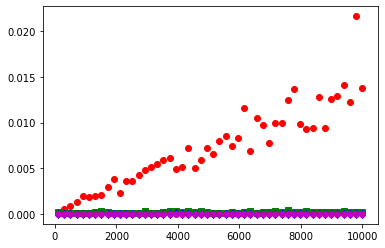

In [4]:
plt.plot(ns, ts_linsearch, 'or') #size of the list only affects linear search
plt.plot(ns, ts_binsearch, 'sg')
plt.plot(ns, ts_setsearch, 'db')
plt.plot(ns, ts_dctsearch, 'om')

![img](c330ab22e12845d0448e5bd0545018bfe8504f19.png)

It looks like sets and dictionaries support lookup in constant time!
How?!



## The `map` ADT



We will focus next on the "*map*" abstract data type (aka "associative
array" or "dictionary"), which is used to associate keys (which must be
unique) with values. Python's `dict` type is an implementation of the
map ADT.

Given an implementation of a map, it is trivial to implement a *set* on
top of it (how?).

Here's a simple map API:



In [17]:
class MapDS:
    def __init__(self):
        self.data = {}

    def __setitem__(self, key, value):
        self.data[key] = value

    def __getitem__(self, key):
        return self.data[key]

    def __contains__(self, key):
        return self.data.__contains__(key)

In [6]:
m = MapDS()
m['batman'] = 'bruce wayne'
m['superman'] = 'clark kent'
m['spiderman'] = 'peter parker'

In [7]:
m['batman']

'bruce wayne'

In [8]:
m['batman'] = 'tony stark'

In [9]:
m['batman']

'tony stark'

In [18]:
class SetDS:

    def __init__(self):
        self.data = MapDS()
    
    def add(self, v):
        self.data[v] = True

    def __contains__(self, v):
        return self.data.__contains__(v)

In [21]:
s = SetDS()
s.add("Batman")
s.add("Superman")
print("Batman" in s)
print("Superman" in s)
print("Ironman" in s)

True
True
False


## Direct lookups via *Hashing*



Hashes (a.k.a. hash codes or hash values) are simply numerical values
computed for objects.



In [27]:
class SmallIntMap:

    def __init__(self, n=5):
        self.n = n
        self.data = [None] * n

    def __setitem__(self, k, v):
        assert instanceof(k, int) and k >= 0 and k < self.n
        self.data[k] = v

    def __getitem__(self, k):
        assert self.data[k]
        return self.data[k]
    
    def __delitem__(self, k):
        assert self.data[k]
        self.data[k] = None

    def __contains__(self, k):
        return self[k]

    def __repr__(self):
        return "{" + ",".join([str(k) + " -> " + str(self.data[k]) for k in range(0, self.n)]) + "}"

    def __str__(self):
        return self.__repr__()

In [33]:
hash('hello')

4738890733049818256

In [34]:
hash('batman')

-2146794272483885325

In [35]:
hash('batmen')

-4865666981011522474

In [43]:
[hash(s) for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[-2582145461875759322,
 1110576720105168595,
 -6157151688126466273,
 -5875409629756145547,
 -2582145461875759322,
 -3503891184628651690]

In [44]:
[hash(s)%100 for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[78, 95, 27, 53, 78, 10]

## Hashtables



In [49]:
class NaiveExtensibleHashMap:

    def __init__(self, n=100):
        self.n = n
        self.data = [None] * n

    def extend(self):
        newdata = [None] * 2 * n
        for el in self.data:
            hnew = hash(el[0]) % (self.n * 2)
            newdata[hnew] = el[1]
        self.n *= 2
        self.data = newdata

    def __setitem__(self, k, v):
        h = hash(k) % self.n
        if self.data[h] and self.data[h][1] != k:
            self.extend()
            h = hash(k) % self.n
        self.data[h] = (k, v)

    def __getitem__(self, k):
        h = hash(k) % self.n
        assert self.data[h] and self.data[h][0] == k
        return self.data[h][1]
    
    def __delitem__(self, k):
        h = hash(k) % self.n
        if self.data[h] and self.data[h][0] == k:
            self.data[h] = None

    def __contains__(self, k):
        h = hash(k) % self.n
        return self[h][0] == k

    def __repr__(self):
        return "{" + ",".join([str(self.data[k][0]) + " -> " + str(self.data[k][1]) for k in range(0, self.n) if self.data[k]]) + "}"

    def __str__(self):
        return self.__repr__()

### Problem: collisions -> k1 and k2 are mapped to the same hashbucket
### Make an extensible hashtable (make larger) -> very sensitive to collisons and will lead to much larger than needed data set
### Chaining -> append it to the list assigned to each key. To find it go to the key and do a linear search for the actual value.

In [50]:
class Hashtable:
    def __init__(self, n_buckets):
        self.buckets = [[]] * n_buckets

    def __setitem__(self, key, val):
        h = hash(key)
        bucket = self.buckets[h % len(self.buckets)]
        for k in bucket:
             if(k[0] == key):
                 k[1] = val
        bucket.append([key,val])

    def __getitem__(self, key):
        h = hash(key)
        for k in self.buckets[h % len(self.buckets)]:
            if(k[0] == key):
                 return k[1]
        raise Exception(f"key {key} not in hashtable")

    def __contains__(self, key):
        try:
            _ = self[key]

            return True
        except:
            return False

In [52]:
ht = Hashtable(100)
ht['spiderman'] = 'peter parker'
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'

In [53]:
ht['spiderman']

'peter parker'

In [54]:
ht['batman']

'bruce wayne'

In [55]:
ht['superman']

'clark kent'

In [56]:
ht['superman'] = 'bob'
ht['superman']

'bob'

## On Collisions



### The "Birthday Problem"



Problem statement: Given $N$ people at a party, how likely is it that at
least two people will have the same birthday?



In [57]:
def birthday_p(n_people):
    p_inv = 1
    for n in range(365, 365-n_people, -1):
        p_inv *= n / 365
    return 1 - p_inv

In [67]:
birthday_p(10)

0.11694817771107768

In [59]:
1-364/365*363/365

0.008204165884781456

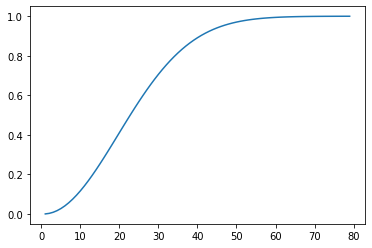

In [60]:
n_people = range(1, 80)
plt.plot(n_people, [birthday_p(n) for n in n_people]);

### General collision statistics



Repeat the birthday problem, but with a given number of values and
"buckets" that are allotted to hold them. How likely is it that two or
more values will map to the same bucket?



In [1]:
def collision_p(n_values, n_buckets):
    p_inv = 1
    for n in range(n_buckets, n_buckets-n_values, -1):
        p_inv *= n / n_buckets
    return 1 - p_inv

In [2]:
collision_p(50, 1000) # same as birthday problem, for 23 people

0.7122686568799875

In [70]:
collision_p(10, 100)

0.37184349044470544

In [71]:
collision_p(100, 1000)

0.9940410733677595

In [1]:
# keeping number of values fixed at 100, but vary number of buckets: visualize probability of collision
n_buckets = range(100, 100001, 1000)
plt.plot(n_buckets, [collision_p(100, nb) for nb in n_buckets]);

In [1]:
def avg_num_collisions(n, b):
    """Returns the expected number of collisions for n values uniformly distributed
    over a hashtable of b buckets. Based on (fairly) elementary probability theory.
    (Pay attention in MATH 474!)"""
    return n - b + b * (1 - 1/b)**n

In [1]:
avg_num_collisions(28, 365)

    1.011442040700615



In [1]:
avg_num_collisions(1000, 1000)

    367.6954247709637



In [1]:
avg_num_collisions(1000, 10000)

    48.32893558556316



## Dealing with Collisions



To deal with collisions in a hashtable, we simply create a "chain" of
key/value pairs for each bucket where collisions occur. The chain needs
to be a data structure that supports quick insertion &#x2014; natural choice:
the linked list!



In [5]:
class Hashtable:
    class Node:
        def __init__(self, key, val, next=None):
            self.key = key
            self.val = val
            self.next = next

    def __init__(self, n_buckets=1000):
        self.buckets = [None] * n_buckets

    def __setitem__(self, key, val):
        bidx = hash(key) % len(self.buckets)
        n = self.buckets[bidx]
        while n:
            if n.key == key:
                n.val = val
            n = n.next
        self.buckets[bidx] = self.Node(key, val, self.buckets[bidx])

    def __getitem__(self, key):
        bidx = hash(key) % len(self.buckets)
        n = self.buckets[bidx]
        while n:
            if n.key == key:
                return n.val
            n = n.next
        raise KeyError
        
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [6]:
ht = Hashtable(1)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [7]:
ht['batman']

'bruce wayne'

In [8]:
ht['superman']

'clark kent'

In [9]:
ht['spiderman']

'peter parker'

In [10]:
def ht_search(ht, x):
    return x in ht

def init_ht(size):
    ht = Hashtable(size)
    for x in range(size):
        ht[x] = x
    return ht

ns = np.linspace(100, 10_000, 50, dtype=int)
ts_htsearch = [timeit.timeit('ht_search(ht, 0)',
                             #'ht_search(ht, {})'.format(random.randrange(n)),
                             setup='ht = init_ht({})'.format(n),
                             globals=globals(),
                             number=100)
               for n in ns]

NameError: name 'np' is not defined

In [1]:
plt.plot(ns, ts_binsearch, 'ro')
plt.plot(ns, ts_htsearch, 'gs')
plt.plot(ns, ts_dctsearch, 'b^');

## Loose ends



### Open Addressing

Way to deal with collisions (not linear probing or chaining). In case of collisions move over for other buckets using some calculation strategy

- linear probing (see lab 7) -> hash(key), has(key)+1, hash(key) + 2, etc.
- double hashing


### Iteration



In [1]:
class Hashtable(Hashtable):
    def __iter__(self):
        pass

In [13]:
ht = Hashtable(100)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [14]:
for k in ht:
    print(k)

KeyError: 

    
    TypeErrorTraceback (most recent call last)
    <ipython-input-83-43c83c094cda> in <module>
    ----> 1 for k in ht:
          2     print(k)
    
    TypeError: iter() returned non-iterator of type 'NoneType'



### Key ordering



In [15]:
ht = Hashtable()
d = {}
for x in 'banana apple cat dog elephant'.split():
    d[x[0]] = x
    ht[x[0]] = x

In [16]:
for k in d:
    print(k, '=>', d[k])

b => banana
a => apple
c => cat
d => dog
e => elephant


In [17]:
for k in ht:
    print(k, '=>', ht[k])

KeyError: 

### Load factor & Rehashing



It is clear that the ratio of the number of keys to the number of
buckets (known as the **load factor**) can have a significant effect on
the performance of a hashtable.

A fixed number of buckets doesn't make sense, as it might be wasteful
for a small number of keys, and also scale poorly to a relatively large
number of keys. And it also doesn't make sense to have the user of the
hashtable manually specify the number of buckets (which is a low-level
implementation detail).

Instead: a practical hashtable implementation would start with a
relatively small number of buckets, and if/when the load factor
increases beyond some threshold (typically 1), it *dynamically increases
the number of buckets* (typically to twice the previous number). This
requires that all existing keys be *rehashed* to new buckets (why?).



### Uniform hashing



Ultimately, the performance of a hashtable also heavily depends on
hashcodes being *uniformly distributed* &#x2014; i.e., where, statistically,
each bucket has roughly the same number of keys hashing to it. Designing
hash functions that do this is an algorithmic problem that's outside the
scope of this class!



## Runtime analysis & Discussion



For a hashtable with $N$ key/value entries, we have the following
*worst-case runtime complexity*:

-   Insertion: $O(N)$
-   Lookup: $O(N)$
-   Deletion: $O(N)$

Assuming uniform hashing and rehashing behavior described above, it is
also possible to prove that hashtables have $O(1)$ *amortized runtime
complexity* for the above operations. Proving this is also beyond the
scope of this class (but is demonstrated by empirical data).



In [27]:
def all_same_bucket(buckets, items):
    p = (1 / buckets) ** items
    return p

print(all_same_bucket(100, 50))

### Basically impossible as long as we maintain a good fill factor -> generally O(1) for all operations

1.000000000000001e-100


## Vocabulary list



-   hashtable
-   hashing and hashes
-   collision
-   hash buckets & chains
-   birthday problem
-   load factor
-   rehashing

---



## Addendum: On *Hashability*



Remember: *a given object must always hash to the same value*. This is
required so that we can always map the object to the same hash bucket.

Hashcodes for collections of objects are usually computed from the
hashcodes of its contents, e.g., the hash of a tuple is a function of
the hashes of the objects in said tuple:



In [31]:
hash(('two', 'strings'))

-2235155351976356879

    4246727162495154915

This is useful. It allows us to use a tuple, for instance, as a key for
a hashtable.

However, if the collection of objects is *mutable* &#x2014; i.e., we can
alter its contents &#x2014; this means that we can potentially change its
hashcode.\`

If we were to use such a collection as a key in a hashtable, and alter
the collection after it's been assigned to a particular bucket, this
leads to a serious problem: the collection may now be in the wrong
bucket (as it was assigned to a bucket based on its original hashcode)!

For this reason, only immutable types are, by default, hashable in
Python. So while we can use integers, strings, and tuples as keys in
dictionaries, lists (which are mutable) cannot be used. Indeed, Python
marks built-in mutable types as "unhashable", e.g.,



In [1]:
hash([1, 2, 3])

    
    TypeErrorTraceback (most recent call last)
    <ipython-input-88-84d65be9aa35> in <module>
    ----> 1 hash([1, 2, 3])
    
    TypeError: unhashable type: 'list'

That said, Python does support hashing on instances of custom classes
(which are mutable). This is because the default hash function
implementation does not rely on the contents of instances of custom
classes. E.g.,



In [33]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname

In [69]:
s = Student('John', 'Doe')
hash(s)

8794157254306

    298582137



In [72]:
s.fname = 'Jane'
hash(s) # same as before mutation

8794157254306

    298582137

We can change the default behavior by providing our own hash function in
`__hash__`, e.g.,



In [1]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname

    def __hash__(self):
        return hash(self.fname) + hash(self.lname)

In [1]:
s = Student('John', 'Doe')
hash(s)

    7828797879385466672



In [1]:
s.fname = 'Jane'
hash(s)

    -7042091445038950747

But be careful: instances of this class are no longer suitable for use
as keys in hashtables (or dictionaries), if you intend to mutate them
after using them as keys!

